In [1]:
import numpy as np
import pandas as pd
import plot_util
import seaborn as sns

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from scipy.stats import linregress, gmean
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import SparsePCA, PCA

plt.style.use('style.mpl')

In [2]:
# Read in a combined dataframe of all the coding sequence NOSC values.
long_nosc_df = pd.read_csv('../data/genomes/all_ref_prot_NOSC.csv')

# Amino acid properties
aa_nosc_df = pd.read_csv('../data/aa_nosc.csv')

# Reading the monte-carlo samples of proteome NOSC per-genome.
unweighted_nosc_est_df = pd.read_csv('../data/genomes/all_ref_prot_NOSC_unweighted_monte_carlo_samples.csv')

# These are "weighted" i.e. allowing for 5 order of variation in expression.
weighted_nosc_est_df = pd.read_csv('../data/genomes/all_ref_prot_NOSC_weighted_monte_carlo_samples.csv')

# Single files per-organism of proteome level Z_C at different growth rates.
coli_data = pd.read_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv')
yeast_data = pd.read_csv('../data/proteomes/Scer/Xia_proteome_NOSC.csv')
cyano_data = pd.read_csv('../data/proteomes/Synechocystis/Zavrel_proteome_NOSC.csv')

# Unified file of the protein-level measurements.
all_expression_data = pd.read_csv('../data/proteomes/all_protein_measurements.csv')

# Kayser et al has specific O2 consumption rates for E. coli in a chemostat
# TODO: preprocess to convert units so we don't need to do it here. 
kayser_chemostat_df = pd.read_csv('../data/chemostat_data/kayser_chemostat_growth_unit_conv.csv')

# Postma et al has specific O2 consumption rates for Yeast in a chemostat
postma_chemostat_df = pd.read_csv('../data/chemostat_data/postma_chemostat_growth_unit_conv.csv')

# Estimated mmol protein C per gram dry weight in a separate notebook
# Estimate is based on E. coli data, would be a bit different for yeast.
mmol_prot_C_per_gDW_est_df = pd.read_csv('../data/proteomes/Coli/mmol_protC_per_gDW_est.csv', index_col=0)

# Fits of the growth dependence of respiratory NADH consumption.
fit_resp_NADH_consumption_df = pd.read_csv('../data/chemostat_data/respiratory_NADH_consumption_fits.csv', index_col=0)

/opt/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
mask = coli_data.condition == 'glucose_minimal'
mask = np.logical_or(mask, coli_data.condition.str.startswith('chemostat'))
coli_chemostat = coli_data[mask].copy()

# Extract the ribosome profiling data
mask = coli_data.dataset == 'li_2014'
coli_li = coli_data[mask].copy()

# extract schmidt 2016 data in chemostat_conds
coli_schmidt_chemostat = coli_chemostat[coli_data.condition.str.startswith('chemostat_')]

# extract schmidt 2016 minimal media non-stress conds
mm_conds = 'glucose,fructose,galactose,glucosamine,xylose,mannose,glycerol,succinate,fumarate,pyruvate,acetate'.split(',')
mask = np.logical_and(coli_data.condition.isin(mm_conds), 
                      coli_data.dataset == 'schmidt_2016')
coli_schmidt_batch = coli_data[mask].copy()

/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_64231/1194820238.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  coli_schmidt_chemostat = coli_chemostat[coli_data.condition.str.startswith('chemostat_')]


mmol protein C / gDW
median est: 22.72
95% CI: 20.42-25.10
proteome biosyn. ≈ 3.40 +/- 0.30 of respiratory NADH consumption


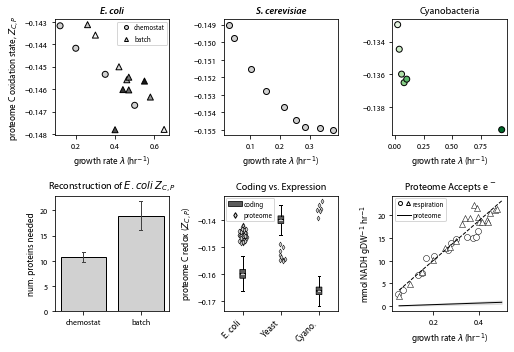

In [4]:
##### Figure 2 -- proteins expressed during faster growth are more reduced 

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(7.24,5))
pal = sns.color_palette()
greys = sns.color_palette('Greys')

# E. coli proteomes from Schmidt 2016
plt.sca(axs[0,0])
sns.scatterplot(data=coli_schmidt_chemostat, x='growth_rate_hr', y='proteome_NOSC',
                style='dataset', markers='o', edgecolor='k', color=greys[1], linewidth=1,
                legend=False)
n_conds_batch = coli_schmidt_batch.condition.unique().size
sns.scatterplot(data=coli_schmidt_batch, x='growth_rate_hr', y='proteome_NOSC',
                hue='condition', palette=sns.color_palette('Greys', n_colors=n_conds_batch), 
                style='dataset', markers='^', edgecolor='k', color=greys[1], linewidth=1,
                legend=False)
plt.title('E. coli', style='italic')
plt.ylabel('proteome C oxidation state, $Z_{C,P}$')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='chemostat',
                          markerfacecolor=greys[1], markeredgecolor='k',
                          linewidth=1, markersize=4),
                   Line2D([0], [0], marker='^', color='w', label='batch',
                          markerfacecolor=greys[1], markeredgecolor='k',
                          linewidth=1, markersize=4)]
plt.gca().legend(handles=legend_elements, loc=1,
                 handletextpad=0.2, borderaxespad=0.3, borderpad=0.3)

# S. cerevisiae proteome data from Xia 2016
plt.sca(axs[0,1])
sns.scatterplot(data=yeast_data, x='growth_rate_hr', y='proteome_NOSC',
                edgecolor='k', color=greys[1], linewidth=1)
plt.title('S. cerevisiae', style='italic')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('')

# Cyanobacterial proteome data from Zavrel 2019
plt.sca(axs[0,2])
# Color by light intensity
n_intensities = cyano_data.red_light_intensity_uE_m_s.unique().size
sns.scatterplot(data=cyano_data, x='growth_rate_hr', y='proteome_NOSC',
                edgecolor='k', color=greys[1], linewidth=1,
                hue='red_light_intensity_uE_m_s',
                palette=sns.color_palette('Greens', n_colors=n_intensities),
                legend=False)
plt.title('Cyanobacteria')
plt.ylabel('')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')

# Z_C,P regression analysis for E. coli proteomes indicates a "diffuse" effect
plt.sca(axs[1,0])

# Read in the output of the lasso regression analysis
lasso_res = pd.read_csv('../data/proteomes/Coli/Schmidt_lasso_regression.csv')
mask = np.logical_and(
    lasso_res.r2 > 0.99,
    lasso_res.r2 < 0.9991)

order = 'chemostat,batch'.split(',')
sns.barplot(data=lasso_res[mask], x='conditions_included', y='number_nonzero', order=order,
            color=greys[1], edgecolor='k', ecolor='k', capsize=0.05, errwidth=1)
plt.ylabel('num. proteins needed')
plt.title('Reconstruction of $E. coli$ $Z_{C,P}$')
plt.xlabel('')

# Coding sequences are not a good predictor of $Z_{C,P}$ in general
# Systematic deviations from coding sequences whose direction depends on the species.
plt.sca(axs[1,1])

# First block the values attained by subsampling the coding sequences
order = 'coli,yeast,PCC6803'.split(',')
labels = dict(coli='E. coli', yeast='Yeast', PCC6803='Cyano.')
for i, org in enumerate(order):
    samples = unweighted_nosc_est_df[unweighted_nosc_est_df.organism == org].NOSC.values
    bp = plt.boxplot(samples, positions=[i], notch=True, showfliers=False, showmeans=False,
                     patch_artist=True, boxprops=dict(facecolor=greys[-2], linewidth=0.75),
                     medianprops=dict(color=greys[1]))
    
# plot range of coli proteome measurements
coli_vals = coli_data.proteome_NOSC.values
xs = np.zeros(coli_vals.size) + np.random.normal(0, 0.05, coli_vals.size)
plt.scatter(xs, coli_vals, marker='d', color=greys[1], edgecolors='k',
            s=12, linewidths=0.5)

# plot range of yeast proteome measurements
yeast_vals = yeast_data.proteome_NOSC.values
xs = np.ones(yeast_vals.size) + np.random.normal(0, 0.05, yeast_vals.size)
plt.scatter(xs, yeast_vals, marker='d', color=greys[1], edgecolors='k',
            s=12, linewidths=0.5)

# plot range of cyano measurements
cyano_vals = cyano_data.proteome_NOSC.values
xs = np.ones(cyano_vals.size)*2 + np.random.normal(0, 0.05, cyano_vals.size)
plt.scatter(xs, cyano_vals, marker='d', color=greys[1], edgecolors='k',
            s=12, linewidths=0.5)

ticks = [labels[o] for o in order]
plt.xticks(np.arange(len(order)), ticks, ha='right', 
           fontsize=9, rotation=45)
plt.ylabel('proteome C redox ($Z_{C,P}$)')
plt.title('Coding vs. Expression')

legend_elements = [bp['boxes'][0], 
                   Line2D([0], [0], marker='d', color='w', label='proteome',
                          markerfacecolor=greys[1], markeredgecolor='k',
                          linewidth=1, markersize=4)]
plt.gca().legend(handles=legend_elements, labels='coding,proteome'.split(','),
                 loc=2, handletextpad=0.2, borderaxespad=0.3, borderpad=0.3)

plt.sca(axs[1, 2])
# Growth rates u range from 0.05 (10 hrs) to 0.5 (80 min) to match data roughly
mus = np.arange(0.05, 0.51, 0.01)

# Assume proteins are produced to match dilution by growth, i.e. degradation is negligible
# as typical lifetimes are longer than generation times. This is more likely to be true
# at higher growth rates.
med_mmolC_per_gDW = mmol_prot_C_per_gDW_est_df.loc[50.0].value
min_mmolC_per_gDW = mmol_prot_C_per_gDW_est_df.loc[2.5].value
max_mmolC_per_gDW = mmol_prot_C_per_gDW_est_df.loc[97.5].value
print('mmol protein C / gDW')
print('median est: {0:.2f}'.format(med_mmolC_per_gDW))
print('95% CI: {0:.2f}-{1:.2f}'.format(min_mmolC_per_gDW, max_mmolC_per_gDW))

protein_C_flux_med = med_mmolC_per_gDW * mus    # mmol aa C / gDW / hr
protein_C_flux_min = min_mmolC_per_gDW * mus    # mmol aa C / gDW / hr
protein_C_flux_max = max_mmolC_per_gDW * mus    # mmol aa C / gDW / hr

min_delta_NOSC = 0.1
protein_e_flux_min = protein_C_flux_min * min_delta_NOSC
max_delta_NOSC = 0.2
protein_e_flux_max = protein_C_flux_max * max_delta_NOSC

e_per_NADH = 2
protein_NADH_flux_min = protein_e_flux_min/e_per_NADH
protein_NADH_flux_max = protein_e_flux_max/e_per_NADH
protein_NADH_flux_med = 0.15*protein_C_flux_med/e_per_NADH

m = fit_resp_NADH_consumption_df.at['slope', 'both_fit']
b = fit_resp_NADH_consumption_df.at['intercept', 'both_fit']
pred_resp_NADH_cons = m*mus + b
plt.plot(mus, pred_resp_NADH_cons, ls='--', color='k', lw=1)
plt.scatter(kayser_chemostat_df.D_per_h, kayser_chemostat_df.r_o2_mmol_NADH_g_h,
            label='$E. coli$ resp.',
            color='w', edgecolors='k', lw=0.5, marker='o')
plt.scatter(postma_chemostat_df.D_per_h, postma_chemostat_df.qO2_mmol_NADH_gDW_hr,
            label='yeast resp.', color='w', edgecolors='k', lw=0.5, marker='^')

plt.fill_between(mus, protein_NADH_flux_min, protein_NADH_flux_max,
                 color=greys[2], alpha=0.3)
l = plt.plot(mus, protein_NADH_flux_med, lw=1, color='k', zorder=10,
             label='proteome')

med_ratio = protein_NADH_flux_med/pred_resp_NADH_cons
med_pct = 100*med_ratio
print('proteome biosyn. ≈ {0:.2f} +/- {1:.2f} of respiratory NADH consumption'.format(
      med_pct.mean(), med_pct.std()))

plt.title('Proteome Accepts e$^-$')
plt.ylabel('mmol NADH gDW$^{-1}$ hr$^{-1}$')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')

line = Line2D([0], [0], color='k', linewidth=1)
circ = Line2D([0], [0], marker='o', color='w',
              markerfacecolor='w', markeredgecolor='k',
              linewidth=1, markersize=4)
tri = Line2D([0], [0], marker='^', color='w',
             markerfacecolor='w', markeredgecolor='k',
             linewidth=1, markersize=4)

legend_elements = [(circ, tri), line]
plt.gca().legend(handles=legend_elements, labels='respiration,proteome'.split(','),
                 loc=2, handletextpad=0.2, borderaxespad=0.3, borderpad=0.3,
                 handler_map={tuple: HandlerTuple(ndivide=None)})

plt.tight_layout()
plt.savefig('../output/Fig2.png', facecolor='w', dpi=300)
plt.show()

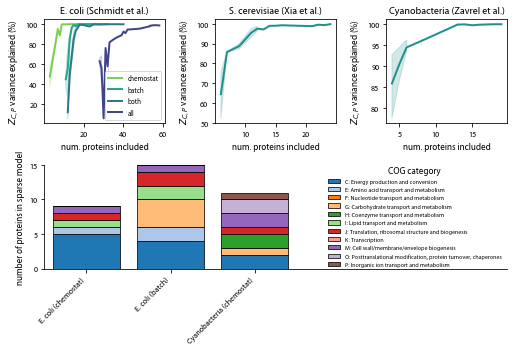

In [5]:
##### Supplementary Fig 1 -- reconstruction of proteome NOSC requires > 5 proteins with distinct functions 
# Maintext has E. coli, here we add yeast and cyanobacteria

# Load results of lasso regression analysis for varying regularization strength alpha
regression_results_df = pd.read_csv('../data/proteomes/all_lasso_regression.csv')
regression_results_df['var_explained_pct'] = 100*regression_results_df.r2
organism_dict = dict(coli='E. coli (Schmidt et al.)', yeast='S. cerevisiae (Xia et al.)', PCC6803='Cyanobacteria (Zavrel et al.)')

# Load COG category analysis at alpha = 1e-8 
long_cat_counts_df = pd.read_csv('../data/proteomes/long_lasso_regression_COG_counts_alpha=1e-08.csv')
COG_cats = pd.read_csv('../data/COG-fun-20.csv').set_index('category')

mosaic = ['A,B,C'.split(','), 'D,D,D'.split(',')]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(7.24,5))

for i, org in zip('ABC', 'coli,yeast,PCC6803'.split(',')):
    plt.sca(axs[i])
    # Get the regression results for this organism, 
    # only considering cases where the model explains some variance
    mask = np.logical_and(
        regression_results_df.organism_key == org,
        regression_results_df.var_explained_pct > 0)
    sns.lineplot(data=regression_results_df[mask], x='number_nonzero', y='var_explained_pct',
                    hue='conditions_included', palette='viridis_r')
    plt.legend(title=None, loc=4)
    if org != 'coli':
        plt.legend().set_visible(False)

    plt.xlabel('num. proteins included')
    plt.ylabel('$Z_{C,P}$ variance explained (%)')
    plt.title(organism_dict[org])

plt.sca(axs['D'])
pal = sns.color_palette('tab20')
j = 0
# Consider only the bacteria since the eukaryotes don't get COG categories
conds = 'coli_chemostat,coli_batch,PCC6803_chemostat'.split(',')
labels = 'E. coli (chemostat),E. coli (batch),Cyanobacteria (chemostat)'.split(',')
n_conds = len(conds)

bottom = np.zeros(n_conds)
xs = np.arange(n_conds)
cat_order = sorted(COG_cats.index.values)
for i, cat in enumerate(cat_order):
    cat_desc = COG_cats.loc[cat].description
    masked = long_cat_counts_df[long_cat_counts_df.COG_category == cat].set_index('organism_condition')
    if masked.number_proteins.sum() == 0:
        continue

    ys = masked.loc[conds].number_proteins.values
    label = '{0}: {1}'.format(cat, cat_desc)
    plt.bar(xs, ys, bottom=bottom, color=pal[j], label=label, edgecolor='k', linewidth=0.75)
    bottom += ys
    j += 1

plt.xlim(-0.5, n_conds+2)
plt.xticks(xs, labels, rotation=45, ha='right')
plt.ylabel('number of proteins in sparse model')
plt.yticks(np.arange(0, 15.1, 5))

l = plt.legend(loc='center right', title='COG category', fontsize=6, frameon=False)
plt.setp(l.get_title(), fontsize=9)
sns.despine(ax=plt.gca())

plt.tight_layout()
plt.savefig('../output/FigS1.png', facecolor='w', dpi=300)
plt.show()

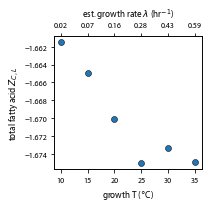

In [6]:
# Read lipid redox data from Marr 1962
total_lipids_marr = pd.read_csv('../data/lipids/Coli/Marr1962_total_lipids_NOSC.csv')

# Model for T-dependent growth rate of E. coli in a similar glucose
# minimal medium to Marr. See Table 1 of Gill 1985 for fit parameters 
b = 0.0262
c = 0.298
Tmax = 47.3
Tmin = 4.9
temps = np.arange(10, 36, 5)
RHS = b*(temps-Tmin)*(1-np.exp(c*(temps-Tmax)))
pred_mu = np.power(RHS, 2)

# Plot T on the primary X axis, inferred growth rate on the top X axis
plt.figure(figsize=(3,3))
pal = sns.color_palette()

mask = total_lipids_marr.experiment == 'temp'
# The fit from Gill 1985 has a max around 40 C
mask = np.logical_and(mask, total_lipids_marr.temp_C < 36)
plt.scatter(total_lipids_marr[mask].temp_C, total_lipids_marr[mask].lipid_NOSC,
            label='Marr 1962', edgecolor='k', lw=0.5, color=pal[0])

plt.xlabel('growth T ($\degree$C)')
plt.ylabel('total fatty acid $Z_{C,L}$')
xlim = plt.xlim()
plt.xticks(temps)

plt.twiny()

plt.xticks(temps, np.round(pred_mu, 2))
plt.xlim(xlim)
plt.xlabel('est. growth rate $\lambda$ (hr$^{-1}$)')

plt.tight_layout()
plt.savefig('../output/FigSX_lipids.png', facecolor='w', dpi=300)
plt.show()

coli mean: -0.15 +/- 0.00
yeast mean: -0.15 +/- 0.00
PCC6803 mean: -0.14 +/- 0.00
coli mean: -0.15 +/- 0.00
yeast mean: -0.15 +/- 0.00
PCC6803 mean: -0.14 +/- 0.00


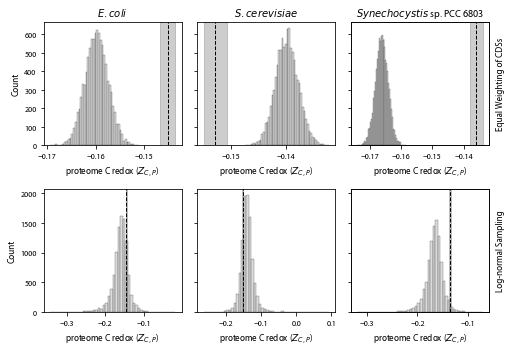

In [7]:
##### Supplementary Fig 2 -- coding sequences are not a good predictor of $Z_{C,P}$
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(7.22,5), sharey='row')
flat_axs = axs.flatten()

coli_vals = coli_data[coli_data.proteome_NOSC.notnull()].proteome_NOSC.values
yeast_vals = yeast_data[yeast_data.proteome_NOSC.notnull()].proteome_NOSC.values
cyano_vals = cyano_data[cyano_data.proteome_NOSC.notnull()].proteome_NOSC.values
means_dict = dict(coli=coli_vals.mean(), yeast=yeast_vals.mean(), PCC6803=cyano_vals.mean())
stds_dict = dict(coli=coli_vals.std(), yeast=yeast_vals.std(), PCC6803=cyano_vals.std())

# Top row compares unweighted sampling to measurements of proteome NOSC
order = 'coli,yeast,PCC6803'.split(',')
labels = dict(coli='$E. coli$', yeast='$S. cerevisiae$', PCC6803='$Synechocystis$ sp. PCC 6803')
for i, org in enumerate(order):
    plt.sca(axs[0, i])
    samples = unweighted_nosc_est_df[unweighted_nosc_est_df.organism == org]
    sns.histplot(data=samples, x='NOSC', bins=50, color=greys[1], edgecolor='k')
    plt.title(labels[org])
    plt.xlabel('proteome C redox ($Z_{C,P}$)')

    print('{0} mean: {1:.2f} +/- {2:.2f}'.format(org, means_dict[org], stds_dict[org]))
    plt.axvline(means_dict[org], color='k', ls='--', lw=1)
    plt.axvspan(means_dict[org]-stds_dict[org], means_dict[org]+stds_dict[org],
                color=greys[-2], alpha=0.3)


for i, org in enumerate(order):
    plt.sca(axs[1, i])
    samples = weighted_nosc_est_df[weighted_nosc_est_df.organism == org]
    sns.histplot(data=samples, x='NOSC', bins=50, color=greys[1], edgecolor='k')
    plt.xlabel('proteome C redox ($Z_{C,P}$)')

    print('{0} mean: {1:.2f} +/- {2:.2f}'.format(org, means_dict[org], stds_dict[org]))
    plt.axvline(means_dict[org], color='k', ls='--', lw=1)
    plt.axvspan(means_dict[org]-stds_dict[org], means_dict[org]+stds_dict[org],
                color=greys[-2], alpha=0.3)

plt.sca(axs[0,2])
twin_ax = plt.gca().twinx()
twin_ax.set_yticklabels([])
twin_ax.tick_params(axis='y', which='both', length=0)
twin_ax.set_ylabel('Equal Weighting of CDSs')

plt.sca(axs[1,2])
twin_ax = plt.gca().twinx()
twin_ax.set_yticklabels([])
twin_ax.tick_params(axis='y', which='both', length=0)
twin_ax.set_ylabel('Log-normal Sampling')

plt.tight_layout()
plt.savefig('../output/FigS2.png', facecolor='w', dpi=300)
plt.show()


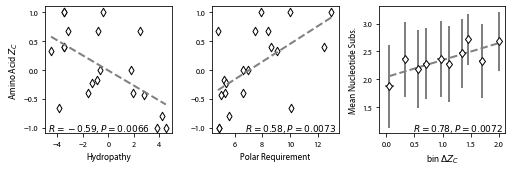

In [8]:
##### Supplementary Fig X -- genetic code is conservative for Z_C.

fig, axs = plt.subplots(ncols=3, figsize=(7.22, 2.5))

plt.sca(axs[0])

mask = np.logical_and(aa_nosc_df.hydropathy.notnull(),
                      aa_nosc_df.NOSC.notnull())
x = aa_nosc_df[mask].hydropathy
y = aa_nosc_df[mask].NOSC
reg = linregress(x, y)

pred_xs = np.arange(x.min(), x.max()*1.01, 0.1)
pred_y = reg.slope*pred_xs + reg.intercept

plt.scatter(x, y, marker='d', color='w', edgecolors='k', lw=1)
plt.plot(pred_xs, pred_y, marker='', ls='--', color='grey')
plt.text(0.02, 0.02, '$R={0:.2f}, P={1:.2g}$'.format(reg.rvalue, reg.pvalue),
         ha='left', fontsize=9, transform=plt.gca().transAxes)
plt.xlabel('Hydropathy')
plt.ylabel('Amino Acid $Z_C$')

plt.sca(axs[1])

mask = np.logical_and(aa_nosc_df.polar_requirement.notnull(),
                      aa_nosc_df.NOSC.notnull())
x = aa_nosc_df[mask].polar_requirement
y = aa_nosc_df[mask].NOSC
reg = linregress(x, y)

pred_xs = np.arange(x.min(), x.max()*1.01, 0.1)
pred_y = reg.slope*pred_xs + reg.intercept

plt.scatter(x, y, marker='d', color='w', edgecolors='k', lw=1)
plt.plot(pred_xs, pred_y, marker='', ls='--', color='grey')
plt.text(0.98, 0.02, '$R={0:.2f}, P={1:.2g}$'.format(reg.rvalue, reg.pvalue),
         ha='right', fontsize=9, transform=plt.gca().transAxes)
plt.xlabel('Polar Requirement')

plt.sca(axs[2])
codon_subs_mean_df = pd.read_csv('../data/genetic_code/binned_codon_substitutions.csv', index_col=0)
x = codon_subs_mean_df.abs_dNOSC
y = codon_subs_mean_df.hamming_dist
reg = linregress(x, y)

pred_xs = np.arange(x.min(), x.max()*1.01, 0.01)
pred_y = reg.slope*pred_xs + reg.intercept

# hamming distance of codon substitution vs. change in NOSC
# note: symmetric confidence intervals are weird here. can't have > 3 subs
# todo: do non-symmetric
plt.errorbar(x, y, xerr=codon_subs_mean_df.abs_dNOSC_std, yerr=codon_subs_mean_df.hamming_dist_std, 
             marker='d', markeredgecolor='k', color='w', ls='', ecolor='grey')
plt.plot(pred_xs, pred_y, marker='', ls='--', color='grey')
plt.text(0.98, 0.02, '$R={0:.2f}, P={1:.2g}$'.format(reg.rvalue, reg.pvalue),
         ha='right', fontsize=9, transform=plt.gca().transAxes)
plt.xlabel('bin $\Delta Z_C$')
plt.ylabel('Mean Nucleotide Subs.')

plt.tight_layout()
plt.savefig('../output/aa_NOSC_hydrophobicity.png', facecolor='w', dpi=300)
plt.show()

In [34]:
# Consider whether the proteins that change expression levels with growth rate
# have extreme Z_C values. 
groups = all_expression_data.groupby('dataset,growth_mode'.split(','))
for idx, gdf in groups:
    if gdf.growth_rate_hr.unique().size < 3:
        continue

    print(gdf)

      b_number  dataset  strain                         condition  \
0        b3448  li_2014  MG1655                     MOPS complete   
1        b3448  li_2014  MG1655                      MOPS minimal   
43       b1631  li_2014  MG1655                     MOPS complete   
44       b1631  li_2014  MG1655  MOPS complete without methionine   
45       b1631  li_2014  MG1655                      MOPS minimal   
...        ...      ...     ...                               ...   
85693    b0093  li_2014  MG1655  MOPS complete without methionine   
85694    b0093  li_2014  MG1655                      MOPS minimal   
85695    b0355  li_2014  MG1655                     MOPS complete   
85696    b0355  li_2014  MG1655  MOPS complete without methionine   
85697    b0355  li_2014  MG1655                      MOPS minimal   

       growth_rate_hr  copies_per_cell  fg_per_cell      NOSC  NC_per  \
0            1.934364       105.647177     0.002915 -0.031204   706.0   
1            0.738700    

In [9]:
# Prepare data for membrane protein supplementary figure
# 1. Calculate the fraction of measured C atoms that are in the membrane
exp4plotting = all_expression_data.copy()
exp4plotting['transmembrane_C'] = exp4plotting.NC_total * exp4plotting.fraction_transmembrane_C

# Take the sum of C atoms in the membrane for each cond.
cols_agg = dict(copies_per_cell='sum', NC_total='sum', Ce_total='sum', transmembrane_C='sum', growth_mode='first', species='first')
exp_summed = exp4plotting.groupby('dataset,condition,growth_rate_hr'.split(',')).agg(cols_agg).reset_index()
# Normalize -- fraction of total protein C annotated to be in the membrane
exp_summed['tm_C_fraction'] = exp_summed.transmembrane_C / exp_summed.NC_total
exp_summed['tm_C_pct'] = exp_summed.tm_C_fraction*100

# Annotate each experiment
split_names = exp_summed.dataset.str.split('_', expand=True)
labels = split_names[0].str.title() + ' ' + split_names[1] + ' (' + exp_summed.growth_mode + ')'
exp_summed['label'] = labels

# Nice names for organisms
pretty_names = {'coli': '$E. coli$',
                'yeast': '$S. cerevisiae$',
                'PCC6803': 'Cyanobacteria'
               }

pal = sns.color_palette()
org_colors = {'coli': 'w',
              'yeast': pal[1],
              'PCC6803': pal[2],
             }

exp_summed.head()

,dataset,condition,growth_rate_hr,copies_per_cell,NC_total,Ce_total,transmembrane_C,growth_mode,species,tm_C_fraction,tm_C_pct,label
0,li_2014,MOPS complete,1.934364,1.972376e+07,1.979388e+10,-2.873416e+09,7.469595e+08,batch,E. coli,0.037737,3.773689,Li 2014 (batch)
1,li_2014,MOPS complete without methionine,1.569390,1.264914e+07,1.456026e+10,-2.085635e+09,4.431345e+08,batch,E. coli,0.030435,3.043452,Li 2014 (batch)
2,li_2014,MOPS minimal,0.738700,6.372665e+06,7.199098e+09,-1.020722e+09,2.864740e+08,batch,E. coli,0.039793,3.979304,Li 2014 (batch)
3,peebo_2015,glucose_minimal,0.210000,3.309770e+06,4.438966e+09,-6.324929e+08,1.463933e+08,chemostat,E. coli,0.032979,3.297914,Peebo 2015 (chemostat)
4,peebo_2015,glucose_minimal,0.220000,3.324305e+06,4.479156e+09,-6.374814e+08,1.450202e+08,chemostat,E. coli,0.032377,3.237667,Peebo 2015 (chemostat)


coli
LinregressResult(slope=-0.3472713482643443, intercept=-0.12642943905344148, rvalue=-0.7909896066079417, pvalue=2.4337512349058066e-205, stderr=0.008705829874060496, intercept_stderr=0.003818469949911488)
yeast
LinregressResult(slope=-0.27981065204947214, intercept=-0.13210160549795785, rvalue=-0.6420787421375574, pvalue=7.359738214887852e-143, stderr=0.00956896211366333, intercept_stderr=0.0028469557323621748)
PCC6803
LinregressResult(slope=-0.35671544098643604, intercept=-0.13552744124883737, rvalue=-0.7962440970952701, pvalue=8.971841487271947e-158, stderr=0.010150061994119195, intercept_stderr=0.003601933464745214)


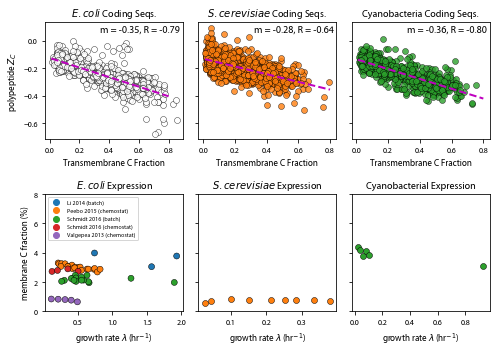

In [10]:
# Fig SY considers membrane proteins as an explanation 
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(7,5), sharey='row')
pal = sns.color_palette()

for i, (name, title) in enumerate(pretty_names.items()): 
    print(name)
    sdf = long_nosc_df[long_nosc_df.organism == name]
    mask = sdf.fraction_transmembrane_C > 1e-3
    tm_prot = sdf[mask]
    
    ax = axs[0, i]
    plt.sca(ax)
    sns.scatterplot(data=tm_prot,
                    x='fraction_transmembrane_C',
                    y='NOSC', color=org_colors[name], edgecolor='k', lw=0.5, alpha=0.8)
    plt.xlabel('Transmembrane C Fraction')
    plt.ylabel('polypeptide $Z_C$')
    
    reg = linregress(tm_prot.fraction_transmembrane_C, tm_prot.NOSC)
    xs = np.arange(0.01, 0.81, 0.01)
    plt.plot(xs, xs*reg.slope + reg.intercept, ls='--', color='m')
    print(reg)
    plt.text(0.98, 0.92, 'm = {0:.2f}, R = {1:.2f}'.format(reg.slope, reg.rvalue), 
             transform=ax.transAxes, ha='right')
    plt.title('{0} Coding Seqs.'.format(title))
    
# E. coli expression figure
plt.sca(axs[1,0])

# All E. coli data, colored by dataset
mask = exp_summed.species == 'E. coli'
coli_all = exp_summed[mask].copy()
sns.scatterplot(data=coli_all, x='growth_rate_hr', y='tm_C_pct',
                hue='label', marker='o', edgecolor='k', lw=1, legend=True)

plt.legend(loc=2, fontsize=6)
plt.ylim(0, 8)
plt.title('$E. coli$ Expression')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('membrane C fraction (%)')

# Yeast expression figure
plt.sca(axs[1,1])

# Extract Xia dataset 
mask = exp_summed.dataset == 'xia_2022'
yeast_xia = exp_summed[mask].copy()
sns.scatterplot(data=yeast_xia, x='growth_rate_hr', y='tm_C_pct',
                color=pal[1], marker='o', edgecolor='k', lw=1, legend=False)

plt.title('$S. cerevisiae$ Expression')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('membrane C fraction (%)')

# Cyano expression figure
plt.sca(axs[1,2])

# Extract Zavrel Cyano dataset 
mask = exp_summed.dataset == 'zavrel_2019'
zavrel_summed = exp_summed[mask].copy()
sns.scatterplot(data=zavrel_summed, x='growth_rate_hr', y='tm_C_pct',
                color=pal[2], marker='o', edgecolor='k', lw=1, legend=False)

plt.title('Cyanobacterial Expression')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('membrane C fraction')

plt.tight_layout()
plt.savefig('../output/tm_proteins.png', facecolor='w', dpi=300)
plt.show()

In [11]:
# Load the data for the NOSC correlation figure
# Description of the bac120 genes
bac120_meta_df = pd.read_csv('../data/gtdb/r207/bac120_msa_marker_info_r207_annot.csv',
                             index_col=0)

# Read the NOSC values for bac120 as a wide-form matrix
bac120_nosc_df = pd.read_csv('../data/gtdb/r207/bac120_nosc_vals_wide.csv', index_col=0)

# Read the correlation matrix for bac120 -- raw correlations first
nosc_corr_df = pd.read_csv('../data/gtdb/r207/bac120_nosc_corr.csv', index_col=[0,1])
# Correlations controlled for mean genome NOSC
nosc_corr_controlled_df = pd.read_csv('../data/gtdb/r207/bac120_nosc_corr_controlled_for_genome_nosc.csv', index_col=[0,1])

0.7932624352511349 ile tRNA syn. ser tRNA syn.
0.4095090511505403 FtsY RadA
0.2022310253031126 RplO PPAT
0.0175372666307355 SecG RecA


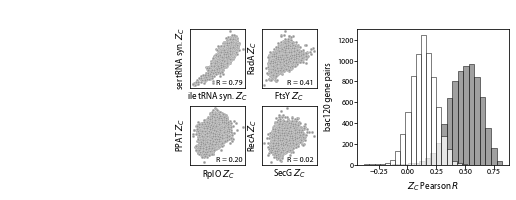

In [12]:
fig = plt.figure(figsize=(7.24, 2.5))
subfigs = fig.subfigures(nrows=1, ncols=3, width_ratios=[1, 1, 1.2])
axsMiddle = subfigs[1].subplots(nrows=2, ncols=2)
axRight = subfigs[2].subplots(nrows=1, ncols=1)

#mosaic = ['A,A,B,C,F,F'.split(','), 'A,A,D,E,F,F'.split(',')]
#fig, axs = plt.subplot_mosaic(mosaic, figsize=(7.24, 2.5))
#fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7,2.5))

pairs = ["TIGR00392,TIGR00414".split(','), "TIGR00064,TIGR00416".split(','),
         "TIGR01071,TIGR01510".split(','), 'TIGR00810,TIGR02012'.split(',') ]
pnames_dict = {
    'TIGR00392': 'ile tRNA syn.',
    'TIGR00414': 'ser tRNA syn.',
    'TIGR00810': 'SecG',
    'TIGR02012': 'RecA',
    'TIGR00064': 'FtsY',
    'TIGR00416': 'RadA',
    'TIGR01071': 'RplO',
    'TIGR01510': 'PPAT',  # pantetheine-phosphate adenylyltransferase
}
greys = sns.color_palette('Greys', n_colors=5)
for ax, gene_ids in zip(axsMiddle.flatten('C'), pairs):
    plt.sca(ax)

    sns.scatterplot(data=bac120_nosc_df, x=gene_ids[0], y=gene_ids[1], s=8, color=greys[2])

    desc0 = pnames_dict[gene_ids[0]]
    desc1 = pnames_dict[gene_ids[1]]
    label_fmt = '{0} $Z_C$'
    plt.xlabel(label_fmt.format(desc0), labelpad=3)
    plt.ylabel(label_fmt.format(desc1), labelpad=3)

    corr = nosc_corr_df.loc[gene_ids[0], gene_ids[1]].r
    print(corr, desc0, desc1)
    plt.text(0.95, 0.05, 'R = {0:.2f}'.format(corr), transform=plt.gca().transAxes, ha='right', fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.tick_params(axis='both', which='both', length=0, pad=0)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.sca(axRight)
pal = sns.color_palette()
sns.histplot(data=nosc_corr_df.r, bins=20, color='grey', edgecolor='k', linewidth=0.5, label='raw')
sns.histplot(data=nosc_corr_controlled_df.r, bins=20, color='w', edgecolor='k', linewidth=0.5, label='controlled')
plt.xlabel('$Z_C$ Pearson $R$')
plt.ylabel('bac120 gene pairs')
#plt.legend(loc=2)
#plt.xlim(-1, 1)
plt.tick_params(axis='both', which='both', pad=0.1)


#plt.tight_layout()
plt.savefig('../output/Fig3.png', facecolor='w', dpi=300,  bbox_inches='tight')
plt.show()


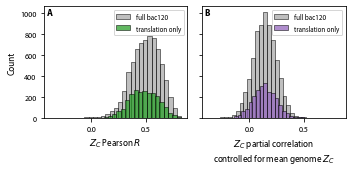

In [13]:
# Fig SX -- dissecting NOSC correlations for bac120 genes
mask = nosc_corr_df.COG_pair == 'J,J'
translation_only = nosc_corr_df[mask]

mask = nosc_corr_controlled_df.COG_pair == 'J,J'
translation_only_corr = nosc_corr_controlled_df[mask]


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5, 2.5), sharex=True, sharey=True)

plt.sca(axs[0])
sns.histplot(data=nosc_corr_df.r, bins=25, color='grey', edgecolor='k',
             linewidth=0.5, label='full bac120', alpha=0.5)
sns.histplot(data=translation_only.r, bins=20, color=pal[2], edgecolor='k',
             linewidth=0.5, label='translation only')
plt.xlabel('$Z_C$ Pearson $R$')
plt.legend(loc=1)

plt.sca(axs[1])
sns.histplot(data=nosc_corr_controlled_df.r, bins=25, color='grey', edgecolor='k',
             linewidth=0.5, alpha=0.5, label='full bac120')
sns.histplot(data=translation_only_corr.r, bins=20, color=pal[4], edgecolor='k',
             linewidth=0.5, label='translation only')
plt.xlabel('$Z_C$ partial correlation\ncontrolled for mean genome $Z_C$')
plt.legend(loc=1)

for label, ax in zip('AB', axs):
    plt.sca(ax)
    plt.text(0.02, 0.98, label, transform=plt.gca().transAxes, ha='left', va='top', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../output/Fig3_S1.png', facecolor='w', dpi=300,  bbox_inches='tight')
plt.show()

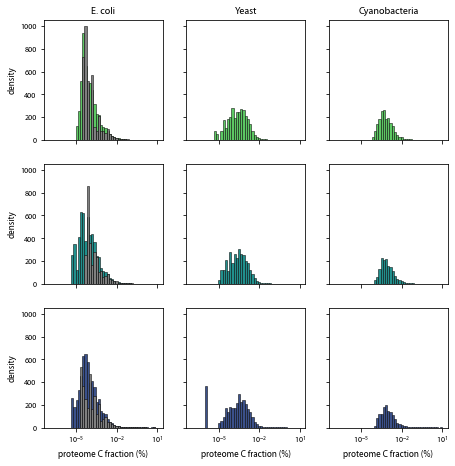

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(7.24, 7.5), sharex=True, sharey=True)
plt.xscale('log')

# E. coli panels.
mask = np.logical_and(long_nosc_df.organism == 'coli',
                      long_nosc_df.primary_COG_category == 'J')
coli_translation_proteins = long_nosc_df[mask]

conds = ['chemostat_u0.12', 'chemostat_u0.35', 'chemostat_u0.5', ]
pal = sns.color_palette('viridis_r', n_colors=len(conds))
bins = np.logspace(-7, 1, 50)
for i, cond in enumerate(conds):
    plt.sca(axs[i, 0])
    mask = np.logical_and(all_expression_data.dataset == 'schmidt_2016',
                          all_expression_data.condition == cond)
    masked = all_expression_data[mask]

    mask2 = np.logical_and(mask, all_expression_data.majority_protein_ids.isin(
        coli_translation_proteins.primary_accession))
    plt.hist(all_expression_data[mask].C_fraction * 100,
             bins=bins, edgecolor='k', linewidth=0.5, color=pal[i], density=True)
    
    plt.hist(all_expression_data[mask2].C_fraction * 100,
             bins=bins, edgecolor='k', linewidth=0.5,
             color='grey', density=True)

conds = ['chemostat_u0.102','chemostat_u0.284', 'chemostat_u0.379', ]
for i, cond in enumerate(conds):
    plt.sca(axs[i, 1])
    mask = np.logical_and(all_expression_data.dataset == 'xia_2022',
                        all_expression_data.condition == cond)
    masked = all_expression_data[mask]
    plt.hist(all_expression_data[mask].C_fraction * 100, bins=bins,
             edgecolor='k', linewidth=0.5, color=pal[i], density=True)

conds = ['photobio_27.5_uE', 'photobio_110_uE', 'photobio_1100_uE']
for i, cond in enumerate(conds):
    plt.sca(axs[i, 2])
    mask = np.logical_and(all_expression_data.dataset == 'zavrel_2019',
                        all_expression_data.condition == cond)
    masked = all_expression_data[mask]
    plt.hist(all_expression_data[mask].C_fraction * 100, bins=bins,
             edgecolor='k', linewidth=0.5, color=pal[i], density=True)
    
for i, title in zip(range(3), 'E. coli,Yeast,Cyanobacteria'.split(',')):
    plt.sca(axs[0, i])
    plt.title(title)
    plt.sca(axs[2, i])
    plt.xlabel('proteome C fraction (%)')
    plt.sca(axs[i, 0])
    plt.ylabel('density')

plt.show()

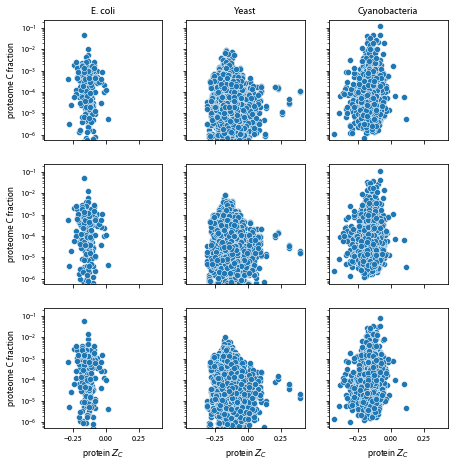

In [15]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(7.24, 7.5), sharex=True, sharey=True)
plt.yscale('log')

# E. coli panels.
mask = np.logical_and(long_nosc_df.organism == 'coli',
                      long_nosc_df.primary_COG_category == 'J')
coli_translation_proteins = long_nosc_df[mask]

conds = ['chemostat_u0.12', 'chemostat_u0.35', 'chemostat_u0.5', ]
pal = sns.color_palette('viridis_r', n_colors=len(conds))
bins = np.logspace(-7, 1, 50)
for i, cond in enumerate(conds):
    plt.sca(axs[i, 0])
    mask = np.logical_and(all_expression_data.dataset == 'schmidt_2016',
                          all_expression_data.condition == cond)
    masked = all_expression_data[mask]

    mask2 = np.logical_and(mask, all_expression_data.majority_protein_ids.isin(
        coli_translation_proteins.primary_accession))
    sns.scatterplot(data=all_expression_data[mask2], x='NOSC', y='C_fraction')

conds = ['chemostat_u0.102','chemostat_u0.284', 'chemostat_u0.379', ]
for i, cond in enumerate(conds):
    plt.sca(axs[i, 1])
    mask = np.logical_and(all_expression_data.dataset == 'xia_2022',
                        all_expression_data.condition == cond)
    masked = all_expression_data[mask]
    sns.scatterplot(data=masked, x='NOSC', y='C_fraction')

conds = ['photobio_27.5_uE', 'photobio_110_uE', 'photobio_1100_uE']
for i, cond in enumerate(conds):
    plt.sca(axs[i, 2])
    mask = np.logical_and(all_expression_data.dataset == 'zavrel_2019',
                        all_expression_data.condition == cond)
    masked = all_expression_data[mask]
    sns.scatterplot(data=masked, x='NOSC', y='C_fraction')
    
for i, title in zip(range(3), 'E. coli,Yeast,Cyanobacteria'.split(',')):
    plt.sca(axs[0, i])
    plt.title(title)
    plt.sca(axs[2, i])
    plt.xlabel('protein $Z_C$')
    plt.sca(axs[i, 0])
    plt.ylabel('proteome C fraction')

plt.show()

In [16]:
mask = coli_translation_proteins.description.str.contains('ligase')
cols = ['primary_accession', 'NC', 'Ce', 'NOSC',
       'gene_name', 'description', 'primary_COG_category',
       'secondary_COG_category']
trnas = coli_translation_proteins[mask]

mask = np.logical_and(all_expression_data.dataset == 'schmidt_2016',
                      all_expression_data.majority_protein_ids.isin(trnas.primary_accession))

for gid, gdf in all_expression_data[mask].groupby('condition'):
    print(gid)
    d = gdf['majority_protein_ids,C_fraction'.split(',')].sort_values('C_fraction', ascending=False).copy()
    d['desc'] = trnas.set_index('primary_accession').loc[d.majority_protein_ids].description.values
    print(d.head(10))
    print()


42C
      majority_protein_ids  C_fraction  \
39743               P07395    0.002762   
12665               P0A8M0    0.002619   
81770               P00956    0.002047   
43232               P00957    0.001863   
84951               P00961    0.001853   
34656               P16659    0.001704   
59127               P07118    0.001370   
6274                P07813    0.001357   
54112               P0A8N3    0.001149   
26789               P00959    0.001137   

                                          desc  
39743  Phenylalanine--tRNA ligase beta subunit  
12665                  Asparagine--tRNA ligase  
81770                  Isoleucine--tRNA ligase  
43232                     Alanine--tRNA ligase  
84951        Glycine--tRNA ligase beta subunit  
34656                     Proline--tRNA ligase  
59127                      Valine--tRNA ligase  
6274                      Leucine--tRNA ligase  
54112                      Lysine--tRNA ligase  
26789                  Methionine--tRNA lig

In [17]:
all_expression_data.columns

Index(['b_number', 'dataset', 'strain', 'condition', 'growth_rate_hr',
       'copies_per_cell', 'fg_per_cell', 'NOSC', 'NC_per', 'num_aas',
       'mw_daltons', 'organism_key', 'species', 'majority_protein_ids',
       'fraction_transmembrane', 'fraction_transmembrane_C', 'growth_mode',
       'stress', 'Ce_per', 'Ce_total', 'NC_total', 'gene_name', 'sample_name',
       'Unnamed: 0', 'red_light_intensity_uE_m_s', 'C_fraction'],
      dtype='object')

In [18]:
coli_translation_proteins.columns

Index(['primary_accession', 'aa_seq', 'num_aas', 'NC', 'Ce', 'NOSC',
       'mw_daltons', 'transmembrane_aas', 'transmembrane_Cs',
       'fraction_transmembrane', 'fraction_transmembrane_C', 'accessions',
       'gene_name', 'description', 'locus_tags', 'GO_terms', 'COG_IDs',
       'KEGG_IDs', 'isoform_accessions', 'KEGG_path_IDs', 'KEGG_pathways',
       'eC_ratio', 'organism', 'b_number', 'primary_COG_category',
       'secondary_COG_category'],
      dtype='object')

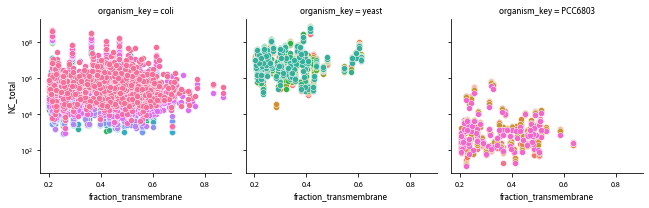

In [19]:
mask  = all_expression_data.fraction_transmembrane > 0.2
tmp = all_expression_data[mask]

g = sns.FacetGrid(tmp, col="organism_key", sharey=True, hue='growth_rate_hr')
g.map(sns.scatterplot, "fraction_transmembrane", "NC_total").set(yscale = 'log')

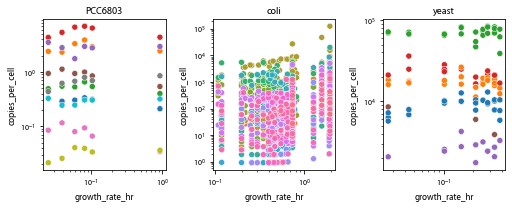

In [20]:
tmp[tmp.fraction_transmembrane > 0.3]

fig, axs = plt.subplots(ncols=3, figsize=(7.22, 3))

for idx, (gid, gdf) in enumerate(tmp[tmp.fraction_transmembrane > 0.5].groupby('organism_key')):
    plt.sca(axs[idx])
    plt.yscale('log')
    plt.xscale('log')
    sns.scatterplot(data=gdf, x='growth_rate_hr', y='copies_per_cell', hue='majority_protein_ids', legend=False)
    plt.title(gid)
    
plt.tight_layout()
plt.show()
#g = sns.FacetGrid(tmp, col="organism_key", row='majority_protein_ids', sharey=True)
#g.map(sns.scatterplot, "growth_rate_hr", "copies_per_cell").set(yscale = 'log')

AttributeError: 'DataFrame' object has no attribute 'ribosomal_protein'

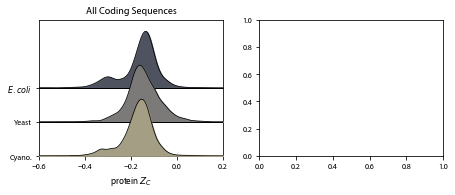

In [21]:
# Fig SX shows the range of NOSC values on proteins
fig, axs = plt.subplots(ncols=2, figsize=(7.24,2.5))

plt.sca(axs[0])
order = 'PCC6803,yeast,coli'.split(',')
labels = dict(coli='$E. coli$', yeast='Yeast', PCC6803='Cyano.')
pal = sns.color_palette('cividis_r', n_colors=len(order), desat=0.4)
plot_util.ridgeplot(long_nosc_df, 'organism', 'NOSC', overlap=0.4,
                    palette=pal, cat_order=order, labels=labels)
plt.xlabel('protein $Z_C$')
plt.title('All Coding Sequences')
plt.xlim(-0.6, 0.2)
plt.ylim(0, 2.4)
    
plt.sca(axs[1])
coli_cds = long_nosc_df[long_nosc_df.organism == 'coli']
cols2copy = 'gene_name,eC_ratio,NOSC,NC,fraction_transmembrane,tag'.split(',')

tm_prot = coli_cds[coli_cds.fraction_transmembrane > 0.3].copy()
rprot_mask = np.logical_or(coli_cds.gene_name.str.startswith('rps'), 
                           coli_cds.gene_name.str.startswith('rpl'))
r_prot = coli_cds[coli_cds.ribosomal_protein].copy()
non_tm = coli_cds[coli_cds.fraction_transmembrane < 0.1].copy()

all_prot = coli_cds.copy()
all_prot['tag'] = 'all'
r_prot['tag'] = 'ribosomal'
tm_prot['tag'] = 'transmembrane'
non_tm['tag'] = 'all non-TM'

dfs = [all_prot, r_prot, tm_prot, non_tm]
tmp_df = pd.concat([d[cols2copy] for d in dfs], ignore_index=True)

order = 'transmembrane,all non-TM,ribosomal'.split(',')
pal = sns.color_palette('viridis_r', n_colors=len(order), desat=0.4)
plot_util.ridgeplot(tmp_df, 'tag', 'NOSC', overlap=0.4,
                    palette=pal, cat_order=order)
    
plt.xlim(-0.6, 0.2)
plt.xlabel('protein $Z_C$')
plt.title('$E. coli$ Coding Sequences')

sns.despine(top=True, left=True, bottom=True, right=True)
plt.tight_layout()
plt.show()